In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

cm = 1/2.54

# 每次调用font dict
fontdict = dict(fontsize=7)

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'


contrast_3 = ['#004488', '#BB5566','#DDAA33']

sns.set_theme(style='ticks', rc={"lines.linewidth": 1, 'font.size': 7, 'legend.fontsize': 7,'legend.title_fontsize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, })

# Decode-Phoneme Sequencing

In [70]:
ref = 'bipolar'

decode_type = 'phoneme'
task = 'PhonemeSequence'

decode_path = BIDSPath(
    datatype=f'(decode){decode_type}',
    root= f'/hpc/group/coganlab/nanlinshi/sharedspace/results/{task}({ref})',
    suffix='highgamma',
    check=False
).match()

scores = []

for path in decode_path:
    mat = h5py.File(path, 'r')
    # (n_folds,)
    acc = mat['accuracy'][()]
    # 可能是标量，也可能是 (n_folds,)
    p_value = mat['p_value'][()]
    # (n_folds, n_perm)
    perm_scores = mat['perm_scores'][()]
    mat.close()

    n_folds = acc.shape[0]

    hemi = 'Left' if path.subject[-1]=='l' else 'Right'
    roi = path.subject[:-1]

    # 如果 p_value 是标量，就扩展成长度为 n_folds 的向量
    p_value_arr = np.array(p_value)
    if p_value_arr.shape == ():
        p_value_arr = np.repeat(p_value_arr, n_folds)

    # 这里我示例用 perm_scores 每个 fold 的平均
    perm_mean = perm_scores.mean(axis=1)  # (n_folds,)

    df = pd.DataFrame({
        'fold': np.arange(n_folds),        # 0,1,2,... 每个 fold 一行
        'score': acc,
        'p_value': p_value_arr,
        'perm': perm_mean,
        'roi': roi,
        'hemi': hemi,
        'description': path.description,
        'datatype': path.datatype.replace('(decode)', ''),
        'phase': path.processing,
        'band': path.suffix,
    })

    scores.append(df)

scores = pd.concat(scores, ignore_index=True)

scores = scores[
    scores.roi.isin(['INS', 'SMC', 'STG'])
]

# rename INS to Insula
scores.roi = scores.roi.replace('INS', 'Insula')

scores.head()

,fold,score,p_value,perm,roi,hemi,description,datatype,phase,band
80,0,0.263158,0.004975,0.108947,Insula,Left,perception,phoneme,1,highgamma
81,1,0.315789,0.004975,0.121053,Insula,Left,perception,phoneme,1,highgamma
82,2,0.157895,0.004975,0.123158,Insula,Left,perception,phoneme,1,highgamma
83,3,0.210526,0.004975,0.128684,Insula,Left,perception,phoneme,1,highgamma
84,4,0.157895,0.004975,0.119211,Insula,Left,perception,phoneme,1,highgamma


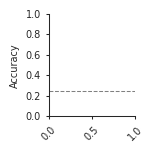

In [71]:
# ① 先算每个 (roi, hemi) 的平均 score

description = 'LM'
phase = 'Go'

roi_hemi_mean = (
    scores[(scores.description==description) & (scores.phase==phase)]
    .groupby(['roi', 'hemi'], as_index=False)['score']
    .mean()
)

# ② 再算每个 roi 的平均分（跨 hemi），用于排序
roi_order = (
    roi_hemi_mean
    .groupby('roi', as_index=False)['score']
    .mean()
    .sort_values('score') 
    .iloc[::-1]# 从低到高；想从高到低就加 .iloc[::-1]
    ['roi']
    .tolist()
)

fig, ax = plt.subplots(figsize=(4*cm, 4*cm))
sns.barplot(
    data=scores[(scores.description==description) & (scores.phase==phase)],
    x='roi',
    y='score',
    hue='hemi',          
    order=roi_order,
    lw=1.5, capsize=0.1,
    palette=[red, red],
    err_kws={'linewidth': .75},   
    dodge=True,
    alpha=1
)

ax.axhline(y=1/4, color='gray', linestyle='--', linewidth=.75)
for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('')
    
    # remove top and right spines
    sns.despine()
    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## square

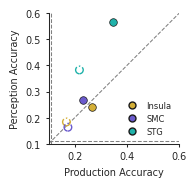

In [56]:
# Perception vs Production scatter plot
phase = '1'

# 按 (roi, hemi) 分别计算 perception 和 production 的平均 score
id_cols = ['roi', 'hemi']

per = scores[scores.description == 'perception'].groupby(id_cols)['score'].mean()
pro = scores[scores.description == 'production'].groupby(id_cols)['score'].mean()

wide = pd.concat({'perception': per, 'production': pro}, axis=1).dropna().reset_index()

# 颜色映射
roi_colors = dict(zip(['Insula', 'SMC', 'STG'], [insula_color, smc_color, stg_color]))

fig, ax = plt.subplots(figsize=(5*cm, 5*cm))

left = wide[wide.hemi == 'Left']
for _, row in left.iterrows():
    ax.scatter(row['production'], row['perception'], 
               c=roi_colors[row['roi']], s=30, edgecolor='k', linewidth=0.5)

# 右脑：空心点（虚线边框）
right = wide[wide.hemi == 'Right']
for _, row in right.iterrows():
    ax.scatter(row['production'], row['perception'],
               facecolors='none', edgecolors=roi_colors[row['roi']], 
               s=30, linewidth=1, linestyle='-.')

# 对角线和 chance level
lim = (0.1, 0.6)
ax.plot(lim, lim, ls='--', c='gray', lw=0.75, zorder=0)
ax.axvline(x=1/9, ls='--', c='gray', lw=0.75)
ax.axhline(y=1/9, ls='--', c='gray', lw=0.75)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')

ax.set_xlabel('Production Accuracy')
ax.set_ylabel('Perception Accuracy')

# Legend
handles = [Line2D([0], [0], marker='o', linestyle='', markerfacecolor=c, 
                  markeredgecolor='k', markersize=5, label=r) 
           for r, c in roi_colors.items()]

ax.legend(handles=handles, loc='lower right', fontsize=6, frameon=False)

for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)

sns.despine()
plt.tight_layout()

fig.savefig(f'../img/fig2/fig2_decode_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

plt.show()

# Time Reolsved

In [72]:
ref = 'bipolar'

task = 'PhonemeSequence'
decode_type = 'phoneme'

result_path = BIDSPath(
    datatype=f'(decode)(resolved){decode_type}',
    root= f'/hpc/group/coganlab/nanlinshi/sharedspace/results/{task}({ref})',
    suffix='highgamma',
    check=False
)

full_path = result_path.match()

scores = []

for path in full_path:
    mat = h5py.File(path, 'r')
    # accuracy: (time, fold)
    accuracy = mat['accuracy'][()]
    # time: (time,)
    time = mat['time'][()]
    # p_value: (time,)
    p_value = mat['p_values'][()]
    # baseline: (time, fold, n_perm)
    baseline = mat['baseline'][()]
    mat.close()

    n_time, n_fold = accuracy.shape

    # ---- 1) baseline 在 perm 维度上平均 → (time, fold) ----
    baseline_mean = baseline.mean(axis=-1)  # shape: (time, fold)

    # ---- 2) 宽表：每列一个 fold（accuracy）----
    df_acc = pd.DataFrame(accuracy, index=time, columns=range(n_fold)).reset_index()
    df_acc = df_acc.rename(columns={'index': 'time'})

    # 宽表 baseline
    df_base = pd.DataFrame(baseline_mean, index=time, columns=range(n_fold)).reset_index()
    df_base = df_base.rename(columns={'index': 'time'})

    # ---- 3) 宽 → 长，显式保留 fold ----
    df_acc = df_acc.melt(
        id_vars='time',
        var_name='fold',
        value_name='accuracy'
    )  # (time * fold, 3)

    df_base = df_base.melt(
        id_vars='time',
        var_name='fold',
        value_name='baseline'
    )

    # 合并 accuracy 和 baseline（按 time, fold 对齐）
    df = df_acc.merge(df_base, on=['time', 'fold'], how='left')

    # ---- 4) p_value 只有 time 维度，就按 time merge ----
    df_p = pd.DataFrame({'time': time, 'p_value': p_value})
    df = df.merge(df_p, on='time', how='left')

    # ---- 5) 加上 path 的元信息 ----
    hemi = 'Left' if path.subject[-1]=='l' else 'Right'
    roi = path.subject[:-1]
    df['roi'] = roi
    df['phase'] = path.processing
    df['hemi'] = hemi
    df['description'] = path.description
    df['datatype'] = path.datatype.replace('(decode)(resolving)', '')
    df['band'] = path.suffix

    scores.append(df)

scores = pd.concat(scores, ignore_index=True)
scores = scores[scores.roi.isin(['INS','STG','SMC'])]
# rename
scores.roi = scores.roi.replace('INS', 'Insula')
scores.head()

,time,fold,accuracy,baseline,p_value,roi,phase,hemi,description,datatype,band
9360,-0.80,0,0.052632,0.111053,0.890547,Insula,1,Left,perception,(decode)(resolved)phoneme,highgamma
9361,-0.78,0,0.000000,0.108421,0.870647,Insula,1,Left,perception,(decode)(resolved)phoneme,highgamma
9362,-0.76,0,0.052632,0.119474,0.616915,Insula,1,Left,perception,(decode)(resolved)phoneme,highgamma
9363,-0.74,0,0.105263,0.102895,0.835821,Insula,1,Left,perception,(decode)(resolved)phoneme,highgamma
9364,-0.72,0,0.105263,0.124737,0.990050,Insula,1,Left,perception,(decode)(resolved)phoneme,highgamma


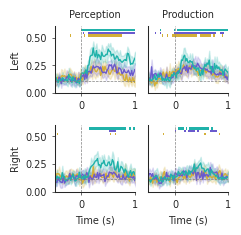

In [60]:
hue_order = ['Insula', 'SMC', 'STG']
roi_colors = dict(zip(hue_order, [insula_color, smc_color, stg_color]))

hemis = ['Left', 'Right']
descs = ['perception', 'production']

fig, axes = plt.subplots(len(hemis), len(descs), figsize=(3*len(descs)*cm, 3*len(hemis)*cm))

# 获取 time 数组（用于 fill_between）
time_arr = scores['time'].unique()
time_arr.sort()

ymax, pad, bar_h = 0.5, 0.01, 0.02

for i, hemi in enumerate(hemis):
    for j, desc in enumerate(descs):
        ax = axes[i, j]
        
        # 画 lineplot
        subset = scores[(scores.description == desc) & (scores.hemi == hemi)]
        sns.lineplot(
            data=subset,
            x='time', y='accuracy', hue='roi',
            palette=roi_colors, hue_order=hue_order,
            ax=ax, legend=False
        )
        
        # 画 significant cluster（每个 roi 一个 bar）
        for k, roi in enumerate(hue_order):
            roi_data = subset[(subset.roi == roi) & (subset.fold == 0)].sort_values('time')
            if roi_data.empty:
                continue
            mask = (roi_data['p_value'].values < 0.05)
            offset = k * (bar_h + 0.005)
            
            if mask.any():
                ax.fill_between(
                    roi_data['time'].values,
                    ymax + pad + offset,
                    ymax + pad + bar_h + offset,
                    where=mask,
                    color=roi_colors[roi],
                    alpha=1,
                    step='mid',
                    linewidth=0
                )

# 统一格式
for i, hemi in enumerate(hemis):
    for j, desc in enumerate(descs):
        ax = axes[i, j]
        ax.tick_params(labelsize=7, width=0.5, length=2)
        plt.setp(ax.spines.values(), linewidth=0.75)
        ax.axvline(x=0, color='gray', linestyle='--', lw=0.5)
        ax.axhline(y=1/9, color='gray', linestyle='--', lw=0.5)
        ax.set_xlim(-0.5, 1)
        ax.set_ylim(0, ymax + pad + len(hue_order)*(bar_h + 0.005) + 0.02)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # 右列去掉 y 轴
        if j == 1:
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        
        # 顶行加标题
        if i == 0:
            ax.set_title(desc.capitalize(), fontsize=7)
        
        # 左列加 hemi 标签
        if j == 0:
            ax.set_ylabel(hemi, fontsize=7)

axes[1, 0].set_xlabel('Time (s)')
axes[1, 1].set_xlabel('Time (s)')

sns.despine()
plt.tight_layout()

fig.savefig(f'../img/fig2/fig2_time_decode_{task}_{ref}.svg', dpi=300, bbox_inches='tight')
plt.show()

# Sentence Rep

In [15]:
ref = 'bipolar'


task = 'SentenceRep'
decode_type = 'word'

decode_path = BIDSPath(
    datatype=f'(decode){decode_type}',
    root= f'/hpc/group/coganlab/nanlinshi/sharedspace/results/{task}({ref})',
    suffix='highgamma',
    check=False
).match()

scores = []

for path in decode_path:
    mat = h5py.File(path, 'r')
    # (n_folds,)
    acc = mat['accuracy'][()]
    # 可能是标量，也可能是 (n_folds,)
    p_value = mat['p_value'][()]
    # (n_folds, n_perm)
    perm_scores = mat['perm_scores'][()]
    mat.close()

    n_folds = acc.shape[0]

    hemi = 'Left' if path.subject[-1]=='l' else 'Right'
    roi = path.subject[:-1]

    # 如果 p_value 是标量，就扩展成长度为 n_folds 的向量
    p_value_arr = np.array(p_value)
    if p_value_arr.shape == ():
        p_value_arr = np.repeat(p_value_arr, n_folds)

    # 这里我示例用 perm_scores 每个 fold 的平均
    perm_mean = perm_scores.mean(axis=1)  # (n_folds,)

    df = pd.DataFrame({
        'fold': np.arange(n_folds),        # 0,1,2,... 每个 fold 一行
        'score': acc,
        'p_value': p_value_arr,
        'perm': perm_mean,
        'roi': roi,
        'hemi': hemi,
        'description': path.description,
        'datatype': path.datatype.replace('(decode)', ''),
        'phase': path.processing,
        'band': path.suffix,
    })

    scores.append(df)

scores = pd.concat(scores, ignore_index=True)

scores = scores[
    scores.roi.isin(['INS', 'SMC', 'STG'])
]

# rename INS to Insula
scores.roi = scores.roi.replace('INS', 'Insula')

scores.head()

,fold,score,p_value,perm,roi,hemi,description,datatype,phase,band
180,0,0.166667,0.552239,0.242500,Insula,Left,JL,word,Audio,highgamma
181,1,0.333333,0.552239,0.258333,Insula,Left,JL,word,Audio,highgamma
182,2,0.200000,0.552239,0.216000,Insula,Left,JL,word,Audio,highgamma
183,3,0.400000,0.552239,0.241000,Insula,Left,JL,word,Audio,highgamma
184,4,0.200000,0.552239,0.220000,Insula,Left,JL,word,Audio,highgamma


In [16]:
roi_hemi_mean = (
    scores[(scores.description==description) & (scores.phase==phase)]
    .groupby(['roi', 'hemi'], as_index=False)['p_value']
    .mean()
)
roi_hemi_mean

,roi,hemi,p_value
0,Insula,Left,0.004975
1,Insula,Right,0.850746
2,SMC,Left,0.920398
3,SMC,Right,0.701493
4,STG,Left,0.169154
5,STG,Right,0.293532


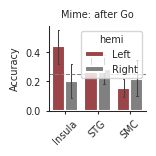

In [17]:
# ① 先算每个 (roi, hemi) 的平均 score

description = 'LM'
phase = 'Go'

roi_hemi_mean = (
    scores[(scores.description==description) & (scores.phase==phase)]
    .groupby(['roi', 'hemi'], as_index=False)['score']
    .mean()
)

# ② 再算每个 roi 的平均分（跨 hemi），用于排序
roi_order = (
    roi_hemi_mean
    .groupby('roi', as_index=False)['score']
    .mean()
    .sort_values('score') 
    .iloc[::-1]# 从低到高；想从高到低就加 .iloc[::-1]
    ['roi']
    .tolist()
)

fig, ax = plt.subplots(figsize=(4*cm, 4*cm))
sns.barplot(
    data=scores[(scores.description==description) & (scores.phase==phase)],
    x='roi',
    y='score',
    hue='hemi',          
    order=roi_order,
    lw=1.5, capsize=0.1,
    palette=[red, 'grey'],
    err_kws={'linewidth': .75},   
    dodge=True,
    alpha=1
)

ax.set_title(f'Mime: after {phase}', fontsize=7)

ax.axhline(y=1/4, color='gray', linestyle='--', linewidth=.75)
for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('')
    
    # remove top and right spines
    sns.despine()
    
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../img/fig2/fig2_decode_LM_Go.svg', dpi=300, bbox_inches='tight')

plt.show()

In [18]:
ref = 'bipolar'

task = 'SentenceRep'
decode_type = 'word'

result_path = BIDSPath(
    datatype=f'(decode)(resolved){decode_type}',
    root= f'/hpc/group/coganlab/nanlinshi/sharedspace/results/{task}({ref})',
    suffix='highgamma',
    check=False
)

full_path = result_path.match()

scores = []

for path in full_path:
    mat = h5py.File(path, 'r')
    # accuracy: (time, fold)
    accuracy = mat['accuracy'][()]
    # time: (time,)
    time = mat['time'][()]
    # p_value: (time,)
    p_value = mat['p_values'][()]
    # baseline: (time, fold, n_perm)
    baseline = mat['baseline'][()]
    mat.close()

    n_time, n_fold = accuracy.shape

    # ---- 1) baseline 在 perm 维度上平均 → (time, fold) ----
    baseline_mean = baseline.mean(axis=-1)  # shape: (time, fold)

    # ---- 2) 宽表：每列一个 fold（accuracy）----
    df_acc = pd.DataFrame(accuracy, index=time, columns=range(n_fold)).reset_index()
    df_acc = df_acc.rename(columns={'index': 'time'})

    # 宽表 baseline
    df_base = pd.DataFrame(baseline_mean, index=time, columns=range(n_fold)).reset_index()
    df_base = df_base.rename(columns={'index': 'time'})

    # ---- 3) 宽 → 长，显式保留 fold ----
    df_acc = df_acc.melt(
        id_vars='time',
        var_name='fold',
        value_name='accuracy'
    )  # (time * fold, 3)

    df_base = df_base.melt(
        id_vars='time',
        var_name='fold',
        value_name='baseline'
    )

    # 合并 accuracy 和 baseline（按 time, fold 对齐）
    df = df_acc.merge(df_base, on=['time', 'fold'], how='left')

    # ---- 4) p_value 只有 time 维度，就按 time merge ----
    df_p = pd.DataFrame({'time': time, 'p_value': p_value})
    df = df.merge(df_p, on='time', how='left')

    # ---- 5) 加上 path 的元信息 ----
    hemi = 'Left' if path.subject[-1]=='l' else 'Right'
    roi = path.subject[:-1]
    df['roi'] = roi
    df['phase'] = path.processing
    df['hemi'] = hemi
    df['description'] = path.description
    df['datatype'] = path.datatype.replace('(decode)(resolving)', '')
    df['band'] = path.suffix

    scores.append(df)

scores = pd.concat(scores, ignore_index=True)
scores = scores[scores.roi.isin(['INS','STG','SMC'])]
# rename
scores.roi = scores.roi.replace('INS', 'Insula')
scores = scores[scores.description=='LM']
scores.head()

,time,fold,accuracy,baseline,p_value,roi,phase,hemi,description,datatype,band
17290,-0.30,0,0.000000,0.280000,0.029851,Insula,Audio,Left,LM,(decode)(resolved)word,highgamma
17291,-0.28,0,0.166667,0.263333,0.567164,Insula,Audio,Left,LM,(decode)(resolved)word,highgamma
17292,-0.26,0,0.166667,0.264167,0.104478,Insula,Audio,Left,LM,(decode)(resolved)word,highgamma
17293,-0.24,0,0.500000,0.275000,0.318408,Insula,Audio,Left,LM,(decode)(resolved)word,highgamma
17294,-0.22,0,0.833333,0.258333,0.059701,Insula,Audio,Left,LM,(decode)(resolved)word,highgamma


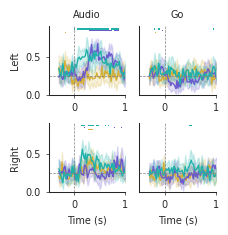

In [19]:
hue_order = ['Insula', 'SMC', 'STG']
roi_colors = dict(zip(hue_order, [insula_color, smc_color, stg_color]))

hemis = ['Left', 'Right']
descs = ['Audio', 'Go']

fig, axes = plt.subplots(len(hemis), len(descs), figsize=(3*len(descs)*cm, 3*len(hemis)*cm))

# 获取 time 数组（用于 fill_between）
time_arr = scores['time'].unique()
time_arr.sort()

ymax, pad, bar_h = 0.8, 0.01, 0.02

for i, hemi in enumerate(hemis):
    for j, desc in enumerate(descs):
        ax = axes[i, j]
        
        # 画 lineplot
        subset = scores[(scores.phase == desc) & (scores.hemi == hemi)]
        sns.lineplot(
            data=subset,
            x='time', y='accuracy', hue='roi',
            palette=roi_colors, hue_order=hue_order,
            ax=ax, legend=False
        )
        
        # 画 significant cluster（每个 roi 一个 bar）
        for k, roi in enumerate(hue_order):
            roi_data = subset[(subset.roi == roi) & (subset.fold == 0)].sort_values('time')
            if roi_data.empty:
                continue
            mask = (roi_data['p_value'].values < 0.05)
            offset = k * (bar_h + 0.005)
            
            if mask.any():
                ax.fill_between(
                    roi_data['time'].values,
                    ymax + pad + offset,
                    ymax + pad + bar_h + offset,
                    where=mask,
                    color=roi_colors[roi],
                    alpha=1,
                    step='mid',
                    linewidth=0
                )

# 统一格式
for i, hemi in enumerate(hemis):
    for j, desc in enumerate(descs):
        ax = axes[i, j]
        ax.tick_params(labelsize=7, width=0.5, length=2)
        plt.setp(ax.spines.values(), linewidth=0.75)
        ax.axvline(x=0, color='gray', linestyle='--', lw=0.5)
        ax.axhline(y=1/4, color='gray', linestyle='--', lw=0.5)
        ax.set_xlim(-0.5, 1)
        ax.set_ylim(0, ymax + pad + len(hue_order)*(bar_h + 0.005) + 0.02)
        # ax.set_ylim(0, 1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # 右列去掉 y 轴
        if j == 1:
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        
        # 顶行加标题
        if i == 0:
            ax.set_title(desc.capitalize(), fontsize=7)
        
        # 左列加 hemi 标签
        if j == 0:
            ax.set_ylabel(hemi, fontsize=7)

axes[1, 0].set_xlabel('Time (s)')
axes[1, 1].set_xlabel('Time (s)')

sns.despine()
plt.tight_layout()

fig.savefig(f'../img/fig2/fig2_time_decode_{task}_{ref}.svg', dpi=300, bbox_inches='tight')
plt.show()